Fold 1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7, Loss: 39.52956199645996
Epoch 2/7, Loss: 36.70497921534947
Epoch 3/7, Loss: 38.28670447213309
Epoch 4/7, Loss: 36.35646792820522
Epoch 5/7, Loss: 38.40201187133789
Epoch 6/7, Loss: 34.012523242405486
Epoch 7/7, Loss: 35.51672036307199
Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       0.13      0.60      0.21         5
           1       0.00      0.00      0.00        27
           2       0.48      0.70      0.57        20

    accuracy                           0.33        52
   macro avg       0.20      0.43      0.26        52
weighted avg       0.20      0.33      0.24        52



C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarnin

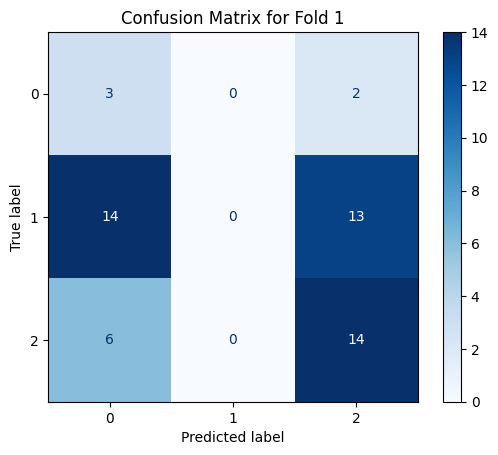

Fold 2


AttributeError: 'Tensor' object has no attribute 'iloc'

In [2]:
import os
import re
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Helper function to extract data from text files
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids


# Helper function to load labels
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Class', 'Age', 'Converted-MMSE']]


# Feature engineering: Calculate text and timing features
def extract_features(texts):
    features = []
    for text in texts:
        interrupter_count = len(re.findall(r'\(.*?\)', text))  # Count interruptions in parentheses
        cleaned_text = re.sub(r'\(.*?\)', '', text)  # Remove parentheses content
        words = re.findall(r'\b\w+\b', cleaned_text)
        stutter_words = len(re.findall(r'\b(er|um|oh|ah|mm)\b', cleaned_text))
        meaningful_words = len(words) - stutter_words
        unique_words = len(set(words))
        word_count = len(words)
        features.append({
            'word_count': word_count,
            'stutter_words': stutter_words,
            'meaningful_words': meaningful_words,
            'unique_words': unique_words,
            'interrupter_count': interrupter_count,
        })
    return pd.DataFrame(features)


# Custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, texts, additional_features, labels, tokenizer, max_len):
        self.texts = texts
        self.additional_features = additional_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        additional_features = torch.tensor(self.additional_features.iloc[index].values, dtype=torch.float32)
        label = torch.tensor(self.labels[index], dtype=torch.long)

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'additional_features': additional_features,
            'label': label
        }


# Model Definition
class CombinedDistilBERT(torch.nn.Module):
    def __init__(self, num_labels, feature_dim):
        super(CombinedDistilBERT, self).__init__()
        self.bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
        self.fc = torch.nn.Linear(num_labels + feature_dim, num_labels)

    def forward(self, input_ids, attention_mask, additional_features, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).logits
        combined_output = torch.cat((bert_output, additional_features), dim=1)
        final_output = self.fc(combined_output)

        if labels is not None:
            loss_fn = CrossEntropyLoss()
            loss = loss_fn(final_output, labels)
            return loss, final_output
        return final_output


# Load and combine data
base_path = "../process/PROCESS-V1/"
file_pattern = r"Process-rec-\d+__CTD\.txt"
data, record_ids = load_data(file_pattern, base_path)

label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

combined_data = []
for text, record_id in zip(data, record_ids):
    if record_id in labels.index and record_id != 'Process-rec-071':
        row = labels.loc[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'Text': text,
            'Class': row['Class'],
            'Age': row['Age'],
            'Converted-MMSE': row['Converted-MMSE'],
        })

df = pd.DataFrame(combined_data)
df['Class'] = df['Class'].astype('category').cat.codes
df.dropna(inplace=True)

# Extract Features
calculated_features = extract_features(df['Text'])
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(df[['Age', 'Converted-MMSE']])
additional_features = pd.concat([
    calculated_features,
    pd.DataFrame(numeric_features, columns=['Age', 'Converted-MMSE'])
], axis=1)

# Cross-validation setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
max_len = 512
batch_size = 16
num_epochs = 7

all_reports = []
for fold, (train_idx, val_idx) in enumerate(skf.split(df['Text'], df['Class']), 1):
    print(f"Fold {fold}")

    train_dataset = CustomDataset(
        df['Text'].iloc[train_idx].tolist(),
        additional_features.iloc[train_idx],
        df['Class'].iloc[train_idx].tolist(),
        tokenizer,
        max_len
    )
    val_dataset = CustomDataset(
        df['Text'].iloc[val_idx].tolist(),
        additional_features.iloc[val_idx],
        df['Class'].iloc[val_idx].tolist(),
        tokenizer,
        max_len
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = CombinedDistilBERT(num_labels=len(df['Class'].unique()), feature_dim=additional_features.shape[1])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            additional_features = batch['additional_features'].to(device)
            labels = batch['label'].to(device)

            loss, _ = model(input_ids, attention_mask, additional_features, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

    # Validation
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            additional_features = batch['additional_features'].to(device)
            labels = batch['label'].to(device)

            _, outputs = model(input_ids, attention_mask, additional_features, labels)
            preds = torch.argmax(outputs, axis=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    print(f"Classification Report for Fold {fold}:")
    report = classification_report(all_labels, all_preds, output_dict=True)
    all_reports.append(report)
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for Fold {fold}")
    plt.show()

# Average Classification Report
avg_report = pd.DataFrame(all_reports).mean().to_dict()
print("Average Classification Report:")
print(avg_report)
